In [1]:
from PIL import Image
import requests
from transformers import AutoProcessor, LlavaForConditionalGeneration
import torch

#### Load model

In [2]:
model_name = "llava-hf/llava-1.5-7b-hf"

model =  LlavaForConditionalGeneration.from_pretrained(
    model_name,
     torch_dtype=torch.bfloat16,
     attn_implementation="flash_attention_2",
     device_map="auto",
)
model.eval()

# load processor
processor = AutoProcessor.from_pretrained(model_name)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


### Testing

In [3]:
url = "https://www.ilankelman.org/stopsigns/australia.jpg"
image = Image.open(requests.get(url, stream=True).raw)

In [4]:
prompt = "USER: <image>\nDescribe the image. ASSISTANT:"
inputs = processor(images=image, text=prompt, return_tensors="pt").to(model.device)

In [5]:
inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'pixel_values'])

In [6]:
inputs['input_ids'].shape

torch.Size([1, 593])

In [32]:
processor.tokenizer.decode(inputs['input_ids'][0], skip_special_tokens=False)

'<s> USER: <image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><i

In [7]:
inputs['input_ids'][0]

tensor([    1,  3148,  1001, 29901, 29871, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 

In [8]:
inputs['pixel_values'].shape

torch.Size([1, 3, 336, 336])

In [27]:
# Generate
#generate_ids = model.generate(**inputs, max_new_tokens=128)
#processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

'USER:  \nDescribe the image. ASSISTANT: The image depicts a busy city street with a stop sign prominently displayed at the intersection. A black car is driving down the street, and there are several people walking around, some of them carrying handbags. The scene also features a lion statue, adding a unique touch to the urban environment.\n\nIn addition to the stop sign, there are other traffic signs visible in the scene, indicating the importance of traffic regulations in this bustling area. The presence of multiple pedestrians and vehicles highlights the dynamic nature of the city street.'

In [8]:
# pixel_values -> image_features
output = model(**inputs, output_hidden_states=True)

torch.Size([1, 3, 336, 336])
torch.Size([1, 576, 4096])


NameError: name 'quit' is not defined

In [13]:
model.vision_tower

CLIPVisionModel(
  (vision_model): CLIPVisionTransformer(
    (embeddings): CLIPVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (position_embedding): Embedding(577, 1024)
    )
    (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-23): 24 x CLIPEncoderLayer(
          (self_attn): CLIPFlashAttention2(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=1024, out_features=4096,

In [6]:
model.config.vision_feature_layer

-2

In [6]:
model.config.vision_feature_select_strategy

'default'

In [5]:
output = model(**inputs, output_hidden_states=True)

pixel_values : torch.Size([1, 3, 336, 336])
patch_embeds: torch.Size([1, 1024, 24, 24])
patch_embeds flattened : torch.Size([1, 576, 1024])
embeddings : torch.Size([1, 577, 1024])
hidden_states : torch.Size([1, 577, 1024])
hidden_states output -2 layer : torch.Size([1, 577, 1024])
selected_image_feature : torch.Size([1, 577, 1024])
selected_image_feature : torch.Size([1, 576, 1024])
image_features : torch.Size([1, 576, 4096])


NameError: name 'quit' is not defined

pixel_values : torch.Size([1, 3, 336, 336])
patch_embeds: torch.Size([1, 1024, 24, 24])


NameError: name 'quit' is not defined

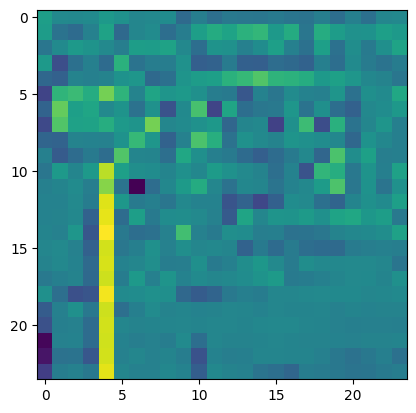

In [5]:
output = model(**inputs, output_hidden_states=True)

In [9]:
torch.rand(1,3,4,4).flatten(2).transpose(1,2).shape

torch.Size([1, 16, 3])

In [10]:
model.config.vision_config

CLIPVisionConfig {
  "attention_dropout": 0.0,
  "hidden_act": "quick_gelu",
  "hidden_size": 1024,
  "image_size": 336,
  "initializer_factor": 1.0,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-05,
  "model_type": "clip_vision_model",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 14,
  "projection_dim": 768,
  "transformers_version": "4.48.0.dev0",
  "vocab_size": 32000
}

In [ ]:
# How to map patch_embeds to pixel_values?

In [14]:
(336 - 14 - 1 - 1)/14

22.857142857142858

In [7]:
# inputs_embeds shape
output = model(**inputs, output_hidden_states=True)

torch.Size([1, 593, 4096])
torch.Size([1, 593, 4096])


NameError: name 'quit' is not defined

In [6]:
output = model(**inputs, output_hidden_states=True)

tensor([[[ 0.0045, -0.0038,  0.0017,  ..., -0.0088,  0.0025, -0.0025],
         [ 0.0026, -0.0275, -0.0051,  ...,  0.0025, -0.0232,  0.0058],
         [-0.0047,  0.0304,  0.0090,  ..., -0.0038, -0.0016,  0.0059],
         ...,
         [-0.0187, -0.0017,  0.0177,  ...,  0.0238,  0.0052,  0.0101],
         [ 0.0066, -0.0161,  0.0117,  ..., -0.0103,  0.0148,  0.0073],
         [ 0.0039,  0.0015,  0.0055,  ..., -0.0042,  0.0151,  0.0024]]],
       device='cuda:0', dtype=torch.bfloat16, grad_fn=<EmbeddingBackward0>)


tensor([[[ 0.0045, -0.0038,  0.0017,  ..., -0.0088,  0.0025, -0.0025],
         [ 0.0026, -0.0275, -0.0051,  ...,  0.0025, -0.0232,  0.0058],
         [-0.0047,  0.0304,  0.0090,  ..., -0.0038, -0.0016,  0.0059],
         ...,
         [-0.0187, -0.0017,  0.0177,  ...,  0.0238,  0.0052,  0.0101],
         [ 0.0066, -0.0161,  0.0117,  ..., -0.0103,  0.0148,  0.0073],
         [ 0.0039,  0.0015,  0.0055,  ..., -0.0042,  0.0151,  0.0024]]],
       device='cuda:0', dtype=torch.bf

NameError: name 'quit' is not defined

In [6]:
output = model(**inputs, output_hidden_states=True)

tensor([[   0,    5,    0],
        [   0,    5,    1],
        [   0,    5,    2],
        ...,
        [   0,  580, 4093],
        [   0,  580, 4094],
        [   0,  580, 4095]], device='cuda:0')


NameError: name 'quit' is not defined

In [6]:
output = model(**inputs, output_hidden_states=True)

tensor([0, 5, 0], device='cuda:0')
tensor([  0,   6, 904], device='cuda:0')
tensor([   0,    6, 1904], device='cuda:0')


NameError: name 'quit' is not defined

In [6]:
model.config.image_token_index

32000

In [11]:
torch.count_nonzero((inputs['input_ids'] == model.config.image_token_index).long())

tensor(576, device='cuda:0')

In [12]:
inputs['pixel_values'].shape

torch.Size([1, 3, 336, 336])

In [13]:
output.keys()

odict_keys(['logits', 'past_key_values', 'hidden_states', 'image_hidden_states'])

In [15]:
len(output['hidden_states'])

33

In [17]:
output['hidden_states'][0].shape

torch.Size([1, 593, 4096])

In [19]:
output['image_hidden_states'].shape

torch.Size([1, 576, 4096])

In [20]:
output['logits'].shape

torch.Size([1, 593, 32064])